I want a better, more realistic way to validate and test strategies for future algorithms. This might include a starting capaital, cost and slippage. I will develop it as I continue. This will hopefully be the base / main testing ground for future strategies, if they work here then they should work in a real world test case.

In [197]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


Important Metrics:
- Max drawdown -- < 30%
- Sharpe / Sortino -- Sharpe > 1.0
- Time in market
- Number of trades -- > 100
- Average trade duration
- Return / drawdown
---

Extra Testing Area:
- Bull vs bear
- High vol vs low vol
- Trending vs ranging
---

Benchmark:
- Sharpe > 1.0
- Max drawdown < 30%
- Trades > 100
- Works across multiple assets
- Survives 2× costs
- Works out-of-sample


In [207]:
cost = 0.0005 # Cost per transaction
capital = 5000 # Starting cap
risk_per_trade = 0.03 # 3%
slippage = 0.1

ticker = 'SPY'
period = '2y' # Length of data
interval = '1d' # Length of each tick

train_split = 0.7

yf_ticker_data = yf.download(ticker, period=period, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Generate signals using defined strategy.

def add_signals(data, fast, slow):    
    data = data.copy()

    data['Fast SMA'] = data['Close'].rolling(window=fast).mean()
    data['Slow SMA'] = data['Close'].rolling(window=slow).mean()
    
    data['Signal'] = np.where(data['Fast SMA'] > data['Slow SMA'], 1, 0)

    data['Signal'] = data['Signal'].shift(1) # very important (t+1) - prevents lookahead
    
    return data.dropna()

In [209]:
# Define where positions should be taken based on signals.

def add_positions(data):
    data = data.copy()

    data['Position'] = np.where((data['Signal'] == 1) & (data['Signal'].shift(1)) == 1, 1, 0) # long only

    return data


In [210]:
def add_position_size(data, capital, risk_per_trade, vol_window=20):
    data = data.copy()

    returns = data['Close'].pct_change()
    vol = returns.rolling(vol_window).std()

    dollar_risk = capital * risk_per_trade

    data['Position Size'] = dollar_risk / vol
    data['Position Size'] = data['Position Size'].clip(upper=capital / data['Close'])

    data['Position Size'] = data['Position Size'].fillna(0)

    return data

In [211]:
# Make trades based on positions - apply cost and slippage

def add_trades(data, cost, slippage_factor, initial_capital):
    data = data.copy()

    returns = data['Close'].pct_change().fillna(0)
    trades = data['Position'].diff().abs().fillna(0)

    vol = returns.rolling(20).std().fillna(0)
    slippage = trades * vol * slippage_factor

    pnl = (data['Position'] * data['Position Size'] * returns * data['Close'])

    costs = trades * cost * data['Position Size'] * data['Close']

    data['PnL'] = pnl - costs - slippage

    data['Capital'] = initial_capital + data['PnL'].cumsum()
    data['Asset Equity'] = initial_capital * (1 + returns).cumprod()
    data['Strategy Equity'] = data['Capital']
    
    return data

In [ ]:
DATA = yf_ticker_data.copy()
DATA.columns = DATA.columns.droplevel(1) 

DATA = add_signals(DATA, 10, 30)
DATA = add_positions(DATA)
DATA = add_position_size(DATA, capital, risk_per_trade)
DATA = add_trades(DATA, cost, slippage, capital)

In [213]:
DATA.tail(15)

Price,Close,High,Low,Open,Volume,Fast SMA,Slow SMA,Signal,Position,Position Size,PnL,Capital,Asset Equity,Strategy Equity
Date,,,,,,,,,,,,,,
2025-12-19,680.590027,681.090027,676.469971,676.590027,103599500,679.516199,674.690725,1.0,1,7.346567,45.317326,6272.696078,6891.588745,6272.696078
2025-12-22,684.830017,685.359985,680.590027,683.940002,69556700,679.837610,675.218620,1.0,1,7.301082,31.149371,6303.845449,6934.522476,6303.845449
2025-12-23,687.960022,688.200012,683.869995,683.919983,64840000,680.530853,675.502875,1.0,1,7.267864,22.852422,6326.697871,6966.216602,6326.697871
2025-12-24,690.380005,690.830017,687.799988,687.950012,39445600,681.014423,675.815951,1.0,1,7.242388,17.588107,6344.285978,6990.721115,6344.285978
2025-12-26,690.309998,691.659973,689.270020,690.640015,41613300,681.331470,676.114063,1.0,1,7.243123,-0.507020,6343.778957,6990.012228,6343.778957
2025-12-29,687.849976,689.200012,686.070007,687.539978,62559500,682.141327,676.707062,1.0,1,7.269027,-17.818241,6325.960717,6965.102283,6325.960717
2025-12-30,687.010010,688.559998,686.580017,687.450012,47160700,682.969885,677.275716,1.0,1,7.277914,-6.105734,6319.854982,6956.596871,6319.854982
2025-12-31,681.919983,687.359985,681.710022,687.140015,74144800,683.474890,677.882756,1.0,1,7.332239,-37.044779,6282.810203,6905.055751,6282.810203
2026-01-02,683.169983,686.869995,679.820007,685.710022,89377200,684.849695,678.717244,1.0,1,7.318823,9.165298,6291.975501,6917.713131,6291.975501


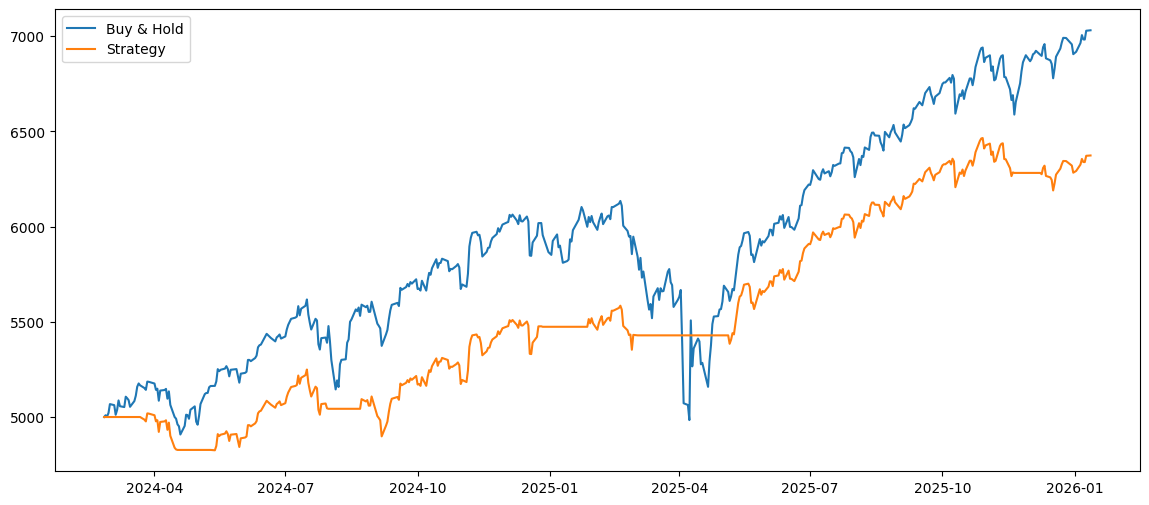

In [214]:
plt.figure(figsize=(14,6))
plt.plot(DATA['Asset Equity'], label='Buy & Hold')
plt.plot(DATA['Strategy Equity'], label='Strategy')
plt.legend()
plt.show()